## Problem 1: Support vector machine implementation using Convex Optimization

In [5]:
def separateClasses(classes,values):
    # this function classifies data corresponding to 1 as -1.0 
    # and target values corresponding to 3 as 1.0
    
    target = np.zeros([values.shape[0],1])
    for i in range(0,target.shape[0]):
        if values[i] == classes[0]:
            target[i] = -1.0
        else:
            target[i] = 1.0
    return target

# import libraries
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
import math
import matplotlib.pyplot as plt
%matplotlib inline

class SVM(object):
    def __init__(self,data,target,c):
        self.C = c # the C parameter
        self.classes = np.unique(target) # different target classes
        self.features = data.shape[1] # number of total features
        self.samples = data.shape[0] # number of data points for the training data
        
    def predictor(self,data,target):
    # This function takes in data and reutrns the classification error
    # for both the training and testing data. The prediction is calculated
    # using y = sign(data * weight + bias)
        prediction = np.zeros(target.shape)
        for i in range(0,data.shape[0]):
            prediction[i] = np.sign(np.dot(data[i,:],self.w)+self.b)
            # use the sign function to classify predictions as -1.0 or 1.0
        error = np.sum(target != prediction)/prediction.shape[0] # calculare the error
        return error
    
    def fit(self, data, target,test_data,test_target):
    # This function runs the fits the Dual Form SVM on the data using 
    # CVXOPT to compute alpha values of the SVM and uses alpha values
    # greater than 1e-4 (threshold) to determine support vectors, bias
    # terms and weights. The computed weights and bias were used to 
    # compute the training error and testing error. 
   
        K = target*data # the kernel function
        P = matrix(np.dot(K,K.T))
        q = matrix(-np.ones([self.samples,1]))
        G = matrix(np.vstack((np.identity(self.samples),-1*np.identity(self.samples))))
        h = matrix(np.vstack((np.ones((self.samples,1))*self.C,np.zeros((self.samples,1)))))
        A = matrix(target.reshape(1,-1))
        b = matrix(np.zeros(1))
        
        solution = solvers.qp(P,q,G,h,A,b)
        alpha = np.array(solution['x'])
        sv = alpha > 1e-4
        self.alpha = alpha[sv].reshape([np.sum(sv),1])
        self.n_sv = np.sum(sv)
        index = np.where(sv)
        self.support_vector = data[index[0],:]
        self.support_vector_y = target[sv].reshape([np.sum(sv),1])
        self.w = np.sum(self.alpha*self.support_vector_y*self.support_vector,axis=0)
        self.margin = 1/np.linalg.norm(self.w)
        temp = np.dot(data,self.w).reshape(target.shape)
        self.b = -(np.min(temp[target==1.]) + np.max(temp[target==-1.]))/2
        train_error = self.predictor(data,target)
        test_error = self.predictor(test_data,test_target)
        return test_error, train_error



def myDuaSVM(filename, C):
    # This function runs the Dual Form SVM on the data 
    # load in the data from csv
    d = np.loadtxt(filename,delimiter=",")
    data = d[:,1:] # data
    data = data/np.linalg.norm(data,axis=1,keepdims=True) # normalize the data
    values = d[:,0] # target values
    classes = np.unique(values) # return the unique target classes
    target = separateClasses(classes,values) # relabel target values at -1.0 and 1.0
    n_folds = 10 # to run the cross fold validation
    
    # create empty arrays to store data
    test_error = np.zeros([n_folds,len(C)])
    train_error = np.zeros([n_folds,len(C)])
    margin = np.zeros([n_folds,len(C)])
    n_sv = np.zeros([n_folds,len(C)])
    
    index = np.arange(data.shape[0])
    solvers.options['show_progress'] = False # prevents solver from printing
    for k in range(0,n_folds):
        test_size = math.floor(data.shape[0]*0.2) # size of test data
        test_index = np.random.choice(d.shape[0],test_size,replace=False) # test data index
        test_data = data[test_index,:] # test data
        test_target = target[test_index]
        train_index = [x for x in index if x not in test_index] # training data index
        train_data = data[train_index,:] # training data
        train_target = target[train_index]
        for i in range(0,len(C)):
            # create SVM model with training data
            model = SVM(train_data,train_target,C[i])
            # fit the model and return the testing error and training error
            test_error[k,i], train_error[k,i] = model.fit(train_data,train_target,test_data, test_target)
            n_sv[k,i] = model.n_sv
            margin[k,i] = model.margin
    # create a dictionary of the data
    dic = {'# Support Vectors (AVG)':np.mean(n_sv,axis=0),'# Support Vectors (STD)': np.std(n_sv,axis=0),
          'Training Error (AVG)':np.mean(train_error,axis=0),'Training Error (STD)': np.std(train_error,axis=0),
          'Testing Error (AVG)': np.mean(test_error,axis=0),'Testing Error (STD)': np.std(test_error,axis=0),
          'Margin (AVG)':np.mean(margin,axis=0),'Margin (STD)': np.std(margin,axis=0)}
    print(pd.DataFrame.from_dict(dic, orient='index',columns = ['C = 0.01','C = 0.1','C = 1','C = 10','C = 100']))
    
    plt.figure()
    plt.subplot(2,2,1)
    plt.bar([str(x) for x in C], dic['Testing Error (AVG)'], xerr=0, yerr=dic['Testing Error (STD)'])
    plt.xlabel('C Value')
    plt.ylabel('Test Error')
    plt.title('Test Error vs C-Value')

    plt.subplot(2,2,2)
    plt.bar([str(x) for x in C], dic['Training Error (AVG)'], xerr=0, yerr=dic['Training Error (STD)'])
    plt.xlabel('C Value')
    plt.ylabel('Training Error')
    plt.title('Training Error vs C-Value')

    plt.subplot(2,2,3)
    plt.bar([str(x) for x in C], dic['# Support Vectors (AVG)'], xerr=0, yerr=dic['# Support Vectors (STD)'])
    plt.xlabel('C Value')
    plt.ylabel('# Support Vectors')
    plt.title('# Support Vectors vs C-Value')

    plt.subplot(2,2,4)
    plt.bar([str(x) for x in C], dic['Margin (AVG)'], xerr=0, yerr=dic['Margin (STD)'])
    plt.xlabel('C Value')
    plt.ylabel('Margin Size')
    plt.title('Margin Size vs C-Value')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    
    
    #return dic

                            C = 0.01     C = 0.1       C = 1     C = 10  \
# Support Vectors (AVG)  1135.500000  339.600000  136.100000  95.200000   
# Support Vectors (STD)     5.371220    4.737088    5.521775   5.325411   
Training Error (AVG)        0.024500    0.016188    0.008875   0.001688   
Training Error (STD)        0.001912    0.001756    0.000875   0.000970   
Testing Error (AVG)         0.027500    0.018750    0.015750   0.016500   
Testing Error (STD)         0.007746    0.006731    0.005596   0.008675   
Margin (AVG)                0.354558    0.217872    0.122937   0.055679   
Margin (STD)                0.000696    0.001099    0.001584   0.000924   

                           C = 100  
# Support Vectors (AVG)  94.400000  
# Support Vectors (STD)   4.247352  
Training Error (AVG)      0.000000  
Training Error (STD)      0.000000  
Testing Error (AVG)       0.013500  
Testing Error (STD)       0.006042  
Margin (AVG)              0.041443  
Margin (STD)              0.

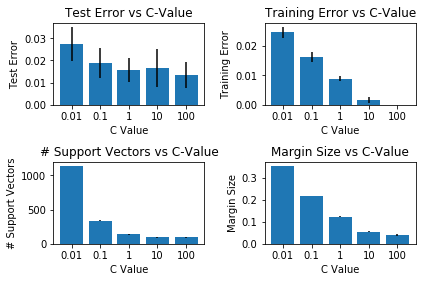

In [6]:
from myDualSVM import *
filename = 'MNIST-13.csv'
C = [0.01,0.1,1,10,100]
myDuaSVM(filename, C)

## Problem 2a: Pegasos Algorithm

In [3]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

def separateClasses(classes,values):
    # this function classifies data corresponding to 1 as -1.0 
    # and target values corresponding to 3 as 1.0
    
    target = np.zeros([values.shape[0],1])
    for i in range(0,target.shape[0]):
        if values[i] == classes[0]:
            target[i] = -1.0
        else:
            target[i] = 1.0
    return target

class Pegasos(object):
    def __init__(self,data,target,l,k,T):
        self.l = l
        self.k = k
        self.T = T
        self.classes = np.unique(target)
        print(data.shape)


    def train(self,data,target):
        # this function is used to train the Pegasos SVM
        
        w = np.zeros([1,data.shape[1]]) # initialize weight vector as 0s
        k_tot = 0 # initialize total number of runs
        loss = [] # initalize loss vector
        t = 0 # initialize run variable
        while (t < self.T) and (k_tot <= 100*data.shape[0]):
            A_data, A_target = self.sample(data,target) # select a subset of the data of k points
            
            # find values of A that correspond to Ay*dot(Ax,weight) < 1
            index = np.arange(0,A_data.shape[0])
            inde = index[((A_target * np.dot(A_data,w.T))<1).reshape(index.shape)]
            A_plus_data = A_data[inde,:]
            A_plus_target = A_target[inde,:]
            # finds the learning rate at the step
            if t == 0:
                lr = 1.0/(self.l)
            else: 
                lr = 1.0/(self.l*t)
            # stochastic subgradient descent step
            w_half = (1. - lr*self.l)*w + (lr/self.k)*np.sum(np.multiply(A_plus_target,A_plus_data),axis=0)
            # projection step
            w = np.minimum(np.float64(1.0),1.0/(np.sqrt(self.l)*np.linalg.norm(w_half)))*w_half
            # add the loss to the vector
            loss.append(self.cost_function(data,target,w))
            # stop the training if the loss of the function decreases
            # below the threshold (1e-5)
            if loss[t] < (1e-3):
                break
            k_tot += 1
            t += 1
        return loss
    
    def sample(self,data,target):
        # this function samples k random points from both classes
        index = np.arange(0,data.shape[0]).reshape([data.shape[0],1])
        index_0 = index[target==self.classes[0]] # index of points of first class
        index_1 = index[target==self.classes[1]] # index of points of second class
        d0 = data[index_0,:] # data of points of first class
        t0 = target[index_0]
        d1 = data[index_1,:] # data of points of second class
        t1 = target[index_1]
        # choose k points from each class
        index_choice_0 = np.random.choice(d0.shape[0],math.ceil((self.k/data.shape[0])*d0.shape[0]),replace=False)
        index_choice_1 = np.random.choice(d1.shape[0],math.ceil((self.k/data.shape[0])*d1.shape[0]),replace=False)
        # create data and target vectors to be used in the SVM
        A_data = np.empty([0,data.shape[1]])
        A_target = np.empty([0,target.shape[1]])
        
        A_data = np.append(A_data,d0[index_choice_0,:],axis=0)
        A_data = np.append(A_data,d1[index_choice_1,:],axis=0)
        A_target = np.append(A_target,t0[index_choice_0,:],axis=0)
        A_target = np.append(A_target,t1[index_choice_1,:],axis=0)
        return A_data,A_target
    def cost_function(self,data,target,w):
        # calculates the cost function of the model based on the data and weights
        loss = 0
        temp = target*np.dot(data,w.T)
        for i in range(data.shape[0]):
            loss += np.maximum(0,1-temp[i]) # compute hinge loss
        loss = loss/data.shape[0]
        return (loss + 0.5*self.l*np.linalg.norm(w)**2) # add regularization term

def myPegasos(filename,k,numruns):
    d = np.loadtxt(filename,delimiter=",")
    data = d[:,1:] # data
    values = d[:,0] # target values
    classes = np.unique(values) # return the unique target classes
    target = separateClasses(classes,values) # relabel target values at -1.0 and 1.0
    timer = []
    loss = {}
    for i in range(numruns):
        start = time.time() # start times
        model = Pegasos(data,target,1,k,200000) # run pegasos for 200,000 runs with lambda = 1
        loss[str(i)] = model.train(data,target) # record loss
        finish = time.time() # end timer
        timer.append(finish-start)
        print(timer[i])
    print("Mean Time: ",np.mean(timer))
    print("STD Time: ",np.std(timer))
    # plot the loss values for each run
    plt.figure()
    plt.title('Pegasos Cost for k = '+str(k))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(loss['0'])),loss['0'])
    plt.plot(range(len(loss['1'])),loss['1'])
    plt.plot(range(len(loss['2'])),loss['2'])
    plt.plot(range(len(loss['3'])),loss['3'])
    plt.plot(range(len(loss['4'])),loss['4'])
    plt.yscale('log')
    plt.show()
    
    
    #return timer, loss

In [ ]:
filename = 'MNIST-13.csv'

k = 1
numruns = 5
myPegasos(filename,k,numruns)

In [ ]:
filename = 'MNIST-13.csv'
k = 20
numruns = 5
myPegasos(filename,k,numruns)

In [ ]:
filename = 'MNIST-13.csv'
k = 200
numruns = 5
myPegasos(filename,k,numruns)

In [ ]:
filename = 'MNIST-13.csv'
k = 1000
numruns = 5
myPegasos(filename,k,numruns)

In [ ]:
filename = 'MNIST-13.csv'
k = 2000
numruns = 5
myPegasos(filename,k,numruns)

## Problem 2b: SoftPlus Algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from myDualSVM_softplus import load_data
from mySoftplus import SoftplusSGD


X, y = load_data("data/MNIST-13.csv")

X = np.hstack((X, np.ones((X.shape[0], 1))))

ks = [1, 20, 200, 1000, 2000]

times = []

for k in ks:
    k_times = []
    k_objective_values = []
    fig, ax = plt.subplots()
    ax.set_title(f"Total Loss (Average w against all data) for k = {k}")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Gradient Computations (Log Scale)')
    ax.set_ylabel('Loss (Log Scale)')
    for i in range(5):
        print("Run:", i)
        sp = SoftplusSGD(np.random.random(X.shape[1]) * 1e-5)
        time, objective_times, objective_values = sp.train(X, y, k=k)
        k_times.append(time)
        ax.plot(objective_times, objective_values)
        errors = np.count_nonzero(y != np.sign(sp.predict(X)))
        print("Train error rate:", errors / X.shape[0])
    plt.show()
    times.append(k_times)
    
times = np.array(times)
print(times)
time_means = times.mean(axis=1)
time_stds = times.std(axis=1)

x = np.arange(time_means.shape[0])
fig, ax = plt.subplots()
ax.bar(x, time_means, yerr=time_stds)
ax.set_xlabel("Value of k")
ax.set_ylabel("Time in seconds")
ax.set_xticks(x)
ax.set_xticklabels([str(x) for x in ks])
ax.set_title("Time against value of k")
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()